But : Voir la diversité dans les chants
- Voir si les chants sélectionnés en fin de nuit sont toujours très proche
- Voir pour chaque chant son nombre de voisin dans la population
- Voir le score des individus de la population
- Voir a quoi ressemble un chant muté par rapport a un chant parent

In [1]:
# -- Dynamic --
%matplotlib notebook
# --- Standard --
# %matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas

from copy import deepcopy
from bisect import bisect_left
import json
from os.path import join
import pickle
from scipy.io import wavfile
import sys

import birdsonganalysis as bsa

# import from current folder
from cmp_2_sim import plot_gesture_starts

# Allow to import the modules in the model folder
sys.path.append('../model/')
from measures import (normalize_and_center,
                      genetic_neighbours,
                      get_scores, 
                      bsa_measure,
                      generate_mat_neighbours_metrics,
                      generate_mat_neighbours_distances)
from song_model import SongModel

fig_width = 16 # full screen: 16 / half screen: 10
fig_height = 5

For each div_th value, look the day where all the songs are neighbours with each others

In [2]:
# """/!\ long calculation """
# l_div_th = [500, 1000, 1500, 2000, 2500, 
#             2750, 3000, 3250, 3500, 3750,
#             4000, 4500, 5000, 5500, 6000]
# l_seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# all_neighbour_index = {}
# for i_div_th, div_th in enumerate(l_div_th):
#     print("{} ({}/{})".format(div_th, i_div_th+1, len(l_div_th)))
#     index_list = []
#     for i_seed in l_seed:
#         print("\t{} ({}/{})".format(i_seed, i_seed+1, len(l_seed)))
#         path = "../model/res/"
#         path += "long_grid_div_th_180821_183837/"
#         path += "seed{}".format(i_seed)
#         path += "+long_grid_div_th+{}_diversity_th".format(div_th)
#         with open(join(path, 'conf.json'), 'r') as f:
#             run_param = json.load(f)
#         with open(join(path, 'data.pkl'), 'rb') as f:
#             songlog = pickle.load(f)
#         night_data = [item[1] for item in songlog if item[0] == 'night']
#         nd = pandas.DataFrame(night_data)
#         eve_index = nd.index[nd['cond'] == 'evening']
#         eve_nd = pandas.DataFrame(nd.iloc[eve_index]['pop'].values, columns=['pop'])
#         i_all_neighbour = 0
#         serie_of_20 = False
#         div_th_value = run_param.get("diversity_threshold", 2000)
#         for i_night in range(run_param['days'] - 1):
#             eve_pop = eve_nd.iloc[i_night]['pop']
#             num_of_neighbours = genetic_neighbours(eve_pop, eve_pop, div_th_value)
#             if num_of_neighbours.tolist().count(20) == len(num_of_neighbours):
#                 if not serie_of_20:
#                     i_all_neighbour = i_night
#                     serie_of_20 = True
#             else:
#                 if serie_of_20:
#                     serie_of_20 = False
#         index_list.append(i_all_neighbour)
#     all_neighbour_index[div_th] = index_list
# print("-------------------------------------------")
# print("-------------------------------------------")
# for k in sorted(all_neighbour_index.keys()):
#     v = all_neighbour_index[k]
#     mean = round(sum(v)/len(v))
#     print("{}: {}".format(k, v), "\tmean: {}".format(mean))

# Get simulation parameters

reminder: for 0.1_0.1_0.75_0.05 short and long

some div_th values: 2500, 2750, 3000, 3250, 3500, 3750,
4000, 4500, 5000, 5500, 6000

2 options:
- results from 1 simulation (1 folder)
- results from a cluster: multiple simulations (1 folder with multiples sub-folders)

In [3]:
# path of the folder with the results
res_path = '../model/res/'

# -- 1 simulation --
path = res_path + 'test_long_div_th_new_params_180920_145921'

# -- Cluster simulations --
# -- All parameters are defined at the same time --
# path = res_path + 'long_grid_div_th_180821_183837/'
# param_name = "seed0+long_grid_div_th+2000_diversity_th"
# path += param_name

# load the parameters used for the simulation
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)

# Get data

In [4]:
# -- Tutor --
sr, tutor = wavfile.read(join(path, 'tutor.wav'))
tutor = normalize_and_center(tutor)
tutor_feat = bsa.all_song_features(tutor, bsa.SR,
                                   freq_range=bsa.FREQ_RANGE,
                                   fft_step=bsa.FFT_STEP,
                                   fft_size=bsa.FFT_SIZE)

measure = lambda x: bsa_measure(x, bsa.SR, 
                                coefs=run_param['coefs'],
                                tutor_feat=tutor_feat) 
comp = lambda g, c: np.linalg.norm(g - c)

goal = measure(tutor)

with open(join(path, 'data.pkl'), 'rb') as f:
    songlog = pickle.load(f)
    
root_data = [item[1] for item in songlog if item[0] == 'root']
rd = pandas.DataFrame(root_data)

night_data = [item[1] for item in songlog if item[0] == 'night']
nd = pandas.DataFrame(night_data)

nb_nights = len(nd) // 4

In [5]:
# rd

In [6]:
# nd

In [7]:
# # -- Little code to plot the alpha and beta functions of a song (parameter: index of rd) --
# for sm in rd.iloc[3]['songs']:
#     plt.figure(figsize=(fig_width,fig_height))
#     ab = sm.gen_alphabeta()
#     gestures = sm.gestures
#     for start, g in gestures:
#         ab[start] = np.nan
#         plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
#     plt.plot(ab[:,0])
#     plt.plot(ab[:,1])
#     plt.xlim(0, ab.shape[0])
#     plt.show()

# Split the data from nd Dataframe

Récupération des 3 chants pour chaque fin de journée avec un index partant de 0

In [8]:
bef_eve_index = nd.index[nd['cond'] == 'before_evening']
bef_eve_nd = pandas.DataFrame(nd.iloc[bef_eve_index]['pop'].values, columns=['pop'])

Récupération des chants en début de nuit (la population de 20) avec un index partant de 0

In [9]:
eve_index = nd.index[nd['cond'] == 'evening']
eve_nd = pandas.DataFrame(nd.iloc[eve_index]['pop'].values, columns=['pop'])

Récupération de la population de 20 chants en fin de nuit, pour chaque nuit

In [10]:
bef_mor_index = nd.index[nd['cond'] == 'before_morning']
bef_mor_nd = pandas.DataFrame(nd.iloc[bef_mor_index]['pop'].values, columns=['pop'])

Récupération des 3 chants pour chaque début de journée

In [11]:
mor_index = nd.index[nd['cond'] == 'morning']
mor_nd = pandas.DataFrame(nd.iloc[mor_index]['pop'].values, columns=['pop'])

Choix d'un indice pour regarder une nuit particulière

In [12]:
i_day = 0
bef_eve_pop = bef_eve_nd.iloc[i_day]['pop']
eve_pop = eve_nd.iloc[i_day]['pop']
bef_mor_pop = bef_mor_nd.iloc[i_day]['pop']
mor_pop = mor_nd.iloc[i_day]['pop']

# Distances between each song of the night population
with asymmetric measure

In [13]:
th = run_param['diversity_threshold']
eve_mat_neigh = generate_mat_neighbours_metrics(eve_pop)
print("night #{}".format(i_day))
print('threshold =', th)
print(eve_mat_neigh)

night #0
threshold = 3500
[[    0.  6436. 25127.  6436. 12198. 25127.  6436.    37.   954. 25127.
   6436.  6436.   512.    65. 25127.   132.  6436. 21967. 25127.  6436.]
 [13836.     0. 11223.   528. 16395. 10863.   610. 13836. 13846. 11223.
    177.   863. 13404. 13781. 11223. 13714.     0. 10433. 11223.    27.]
 [14886.  6660.     0.  5140.  4608.   190.  6918. 14886. 14886.   139.
   5708.  7171. 14886. 14886.    65. 14886.  5156.   278.     0.  6660.]
 [12826.  1485. 11163.     0. 16335. 10973.  2095. 12826. 12836. 11163.
   1662.  2348. 12394. 12771. 11163. 12704.   733. 10373. 11163.  1512.]
 [12582.  7312.  4608.  5792.     0.  4798.  7312. 12545. 12582.  4747.
   6360.  7312. 12582. 12582.  4673. 12582.  5808.  4886.  4608.  7312.]
 [14696.  6490.   190.  4950.  4798.     0.  6748. 14696. 14696.   329.
   5538.  7001. 14696. 14696.   255. 14696.  4986.   468.   190.  6490.]
 [13226.   610. 11481.  1138. 15785. 11121.     0. 13226. 13236. 11481.
    787.   253. 12794. 13171. 11

Distances between each song of the night population with the symmetric distance

In [14]:
# th = run_param['diversity_threshold']
# eve_mat_neigh = generate_mat_neighbours_distances(eve_pop)
# print("night #{}".format(i_day))
# print('threshold =', th)
# print(eve_mat_neigh)

# Number of neighbours for the new population at the beginning of the night, for each night

In [15]:
for i_night in range(run_param['days'] - 1):
    eve_pop = eve_nd.iloc[i_night]['pop']
    print("night #{}".format(i_night+1))
    print(genetic_neighbours(eve_pop, eve_pop, run_param['diversity_threshold']))

night #1
[6. 7. 6. 7. 1. 6. 7. 6. 6. 6. 7. 7. 6. 6. 6. 6. 7. 6. 6. 7.]
night #2
[10.  6.  7.  6.  6.  9.  9.  9.  6.  6.  9.  9.  6.  9.  6.  6.  6. 14.
  6.  9.]
night #3
[11. 11.  9. 11. 11.  9. 11.  9.  9.  9. 11. 11.  9. 11. 11. 11.  9. 11.
  9.  9.]
night #4
[12. 12.  8. 12. 12.  8.  8. 12.  8.  8. 12. 12. 12. 12.  8.  8. 12.  8.
 12. 12.]
night #5
[9. 3. 8. 8. 7. 8. 8. 9. 9. 8. 3. 8. 8. 3. 8. 9. 9. 8. 8. 9.]
night #6
[12. 13.  7. 10.  7. 12.  7.  8.  9.  7.  9. 13. 11.  5.  7.  7.  7.  9.
 10. 12.]
night #7
[6. 8. 3. 8. 5. 8. 8. 4. 5. 2. 8. 8. 5. 3. 8. 8. 6. 5. 3. 3.]
night #8
[10.  9.  9.  3.  9.  9.  9.  9.  9.  4.  8.  8.  6.  9.  8.  9.  9.  9.
  9.  9.]
night #9
[ 5.  9.  6. 10.  9.  8.  5.  5.  9.  5.  7.  3.  5.  7.  5.  5.  8.  7.
  5.  5.]
night #10
[ 4. 11. 13. 10. 12. 12.  4.  7.  8. 11. 11.  4.  7.  4. 13. 12. 12. 14.
  8.  9.]
night #11
[ 5. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.  3. 15. 15. 15.  4.
  3.  2.]
night #12
[8. 5. 7. 7. 5. 8. 8. 7. 5. 7. 7. 7. 7.

# Score of song populations

In [16]:
"""/!\ long calculation"""
all_x = []
all_y = []
all_x.append(np.full(run_param['concurrent'], 0))
all_y.append(rd.iloc[0]['scores'])
smart_cpt = 0
for i in range(1, len(nd)+1):
    if smart_cpt == 0:
        print('night #{}'.format(i // 4 + 1))
    if smart_cpt == 0 or smart_cpt == 3:
        nb_songs = run_param['concurrent']
    else:
        nb_songs = run_param['night_concurrent']
    all_x.append(np.full(nb_songs, i/4))
    all_y.append(get_scores(goal, nd.iloc[i-1]['pop'],
                            measure, comp))
    smart_cpt += 1
    smart_cpt %= 4
# add optimization of the last day
all_x.append(np.full(run_param['concurrent'], run_param['days']-1+1/4))
all_y.append(rd.iloc[-1]['scores'])
print('finish!')

night #1
night #2
night #3
night #4
night #5
night #6
night #7
night #8
night #9
night #10
night #11
night #12
night #13
night #14
night #15
night #16
night #17
night #18
night #19
night #20
night #21
night #22
night #23
night #24
night #25
night #26
night #27
night #28
night #29
night #30
night #31
night #32
night #33
night #34
night #35
night #36
night #37
night #38
night #39
night #40
night #41
night #42
night #43
night #44
night #45
night #46
night #47
night #48
night #49
night #50
night #51
night #52
night #53
night #54
night #55
night #56
night #57
night #58
night #59
finish!


<IPython.core.display.Javascript object>


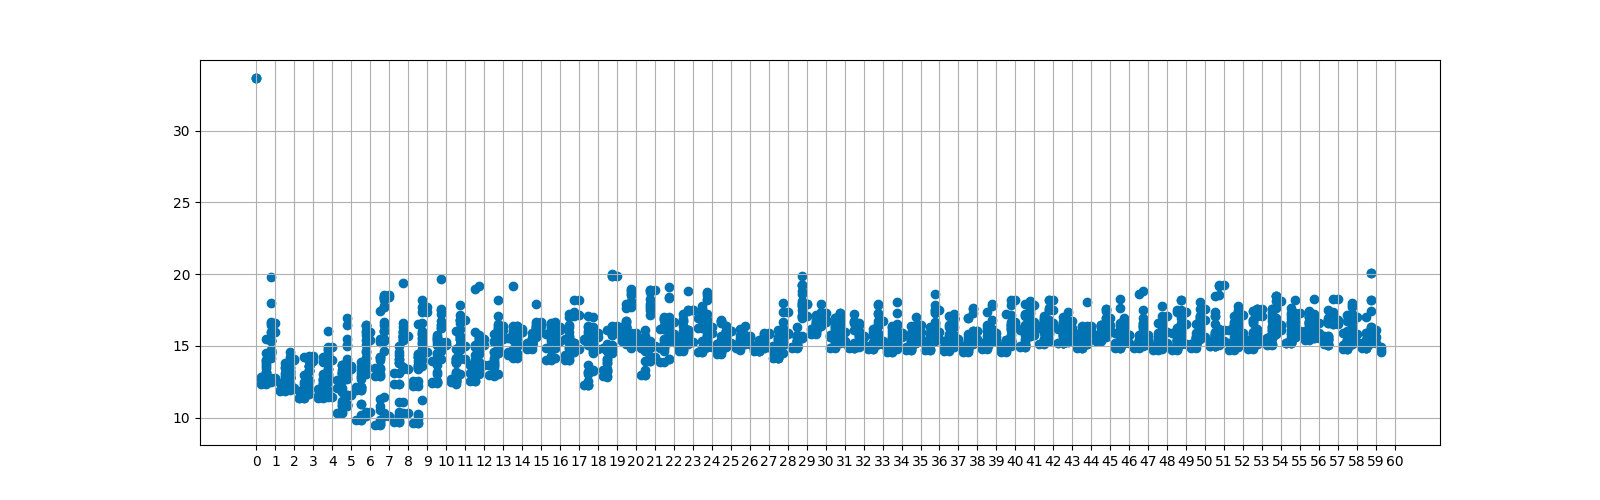

In [28]:
plt.figure(figsize=(fig_width, fig_height))
for i in range(len(all_x)):
    plt.scatter(all_x[i], all_y[i], color='C0')
plt.xticks(np.arange(0, nb_nights+2))
plt.grid()
plt.show()

Regardons l'optimisation du 1er jour

In [18]:
# for i in range(run_param['concurrent']):
#     plt.figure(figsize=(fig_width, fig_height))
#     for index in [0, 1]:
#         ab = rd['songs'].iloc[index][i].gen_alphabeta()
#         gestures = rd['songs'].iloc[index][i].gestures
#         # disable continuity for better plot readability and plot GTE
#         for start, g in gestures:
#             ab[start] = np.nan
#             plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
#         if index == 0:
#             l = ["init alpha", "init beta"]
#             ls = 'dashed'
#         elif index == 1:
#             l = ["optimised alpha", "optimised beta"]
#             ls = 'solid'
#         plt.plot(ab[:,0], label=l[0], ls=ls)
#         plt.plot(ab[:,1], label=l[1], ls=ls)
#         plt.xlim(0, ab.shape[0])
#         plt.title(" song model #{}, index {}".format(i, index))
#         plt.legend()
#     plt.show()

# Evening

Distances entre chaque chant générée en début de nuit

In [19]:
# eve_mat_neigh = mat_neighbours(eve_pop)
# print('threshold =', th)
# print(eve_mat_neigh)

In [20]:
# plot the alpha-beta of all the population
# for sm in eve_nd.iloc[0]['pop']:
#     ab = sm.gen_alphabeta()
#     plt.figure(figsize=(fig_width/2, fig_height/2))
#     # disable continuity for better plot readability and plot GTE
#     for start, g in sm.gestures:
#         ab[start] = np.nan
#         plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
#     plt.plot(ab[:,0], label="alpha")
#     plt.plot(ab[:,1], label="beta")
#     plt.xlim(0, ab.shape[0])
#     plt.show()

# Before morning

In [21]:
# bef_mor_neighbors = genetic_neighbours(bef_mor_pop, bef_mor_pop, th)
# print(th, ":", bef_mor_neighbors)

In [22]:
# bef_mor_mat_neigh = mat_neighbours(bef_mor_pop)
# print(bef_mor_mat_neigh[10:,10:])

In [23]:
# # plot the alpha-beta of all the population
# for sm in bef_mor_nd.iloc[0]['pop']:
#     ab = sm.gen_alphabeta()
#     plt.figure(figsize=(fig_width/2, fig_height/2))
#     # disable continuity for better plot readability and plot GTE
#     for start, g in sm.gestures:
#         ab[start] = np.nan
#         plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
#     plt.plot(ab[:,0], label="alpha")
#     plt.plot(ab[:,1], label="beta")
#     plt.xlim(0, ab.shape[0])
#     plt.show()

# Morning

In [24]:
# for sm in nd.iloc[3]['pop']:
#     plt.figure(figsize=(fig_width, fig_height))
#     ab = sm.gen_alphabeta()
#     gestures = sm.gestures
#     for start, g in gestures:
#         ab[start] = np.nan
#         plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
#     plt.plot(ab[:,0])
#     plt.plot(ab[:,1])
#     plt.xlim(0,ab.shape[0])

# Tests

Regardons les découpes temporelles des chants générés initialement

In [25]:
# print("len(tutor) =", len(tutor))
# for sm in rd.iloc[0]['songs']:
#     plt.figure(figsize=(fig_width, fig_height))
#     plot_gesture_starts([s for s, g in sm.gestures])
#     plt.axvline(len(tutor), color="r", linewidth=1)
#     plt.xlim(-200, 20000)
#     plt.show()
#     print("start of last gesture:", sm.gestures[-1][0])

Dans le modèle, les chants initiaux sont découpés en 10 gestes.

Regardons à quoi ressemblerais une découpe avec plus de gestes, par exemple 20.

In [26]:
# test_rng = np.random.RandomState(run_param['seed'])
# test_songs = [SongModel(song=tutor, priors=run_param['prior'],
#                         nb_split=20, rng=test_rng) for i in range(run_param['concurrent'])]

# for sm in test_songs:
#     plt.figure(figsize=(fig_width, fig_height))
#     plot_gesture_starts([s for s, g in sm.gestures])
#     plt.axvline(len(tutor), color="r", linewidth=1)
#     plt.xlim(-200, 20000)
#     plt.show()